# Simple Quantum-Classical LSTM for Weather Prediction on Jena Climate Dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import pennylane as qml

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
from torch.optim import Adam, AdamW, lr_scheduler

## Dataset

In [6]:
df = pd.read_csv('./jena_climate_2009_2016.csv')

In [7]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [8]:
train_fraction = int(0.72 * df.shape[0])

In [9]:
def Normalize(data, split):
    mean = data[:split].mean(axis=0)
    std = data[:split].std(axis=0)
    return (data - mean) / std # normalize the dataset 

In [10]:
features = df[[df.columns[i+1] for i in [0, 1, 5, 7, 8, 10, 11]]]
features.index = df["Date Time"]
features.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
Date Time,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03
01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72
01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19
01.01.2009 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34
01.01.2009 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32


In [11]:
features = Normalize(features.values, train_fraction)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6
0,0.951438,-2.007202,-1.325129,-0.788750,-1.505680,2.245423,-0.730788
1,0.957517,-2.052433,-1.338173,-0.790835,-1.524244,2.295704,-0.934113
2,0.952653,-2.064031,-1.340782,-0.792921,-1.527957,2.306496,-1.281733
3,0.950222,-2.040836,-1.334260,-0.795007,-1.513106,2.280742,-1.183350
4,0.950222,-2.036197,-1.332955,-0.795007,-1.513106,2.276082,-1.196468


In [12]:
X_train = features.loc[:train_fraction-1]
X_valid = features.loc[train_fraction:]

X_train = X_train[range(7)].values
y_train = np.array(features.iloc[792: 792 + train_fraction][[1]])

### Validation Dataset

In [13]:
valid_end = len(X_valid) - 792
valid_start = train_fraction + 792

In [14]:
X_valid = X_valid.iloc[:valid_end][range(7)].values
y_valid = np.array(features.iloc[valid_start:][[1]])

### PyTorch Dataset

In [15]:
class TimeseriesDataset(Dataset):
    def __init__(self, X, y, sequence_length: int=240, sampling_rate: int=6):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
        self.sequence_length = sequence_length
        self.sampling_rate = sampling_rate
        self.indices = [i for i in range(0, self.X.shape[0] - self.sequence_length, self.sampling_rate)]

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int):
        start_idx = self.indices[idx]
        end_idx = start_idx + self.sequence_length
        return self.X[start_idx:end_idx], self.y[end_idx-1]

In [16]:
WeatherDataset = TimeseriesDataset(X_train, y_train)

In [17]:
print(f"Length of dataset, {len(WeatherDataset)}")

Length of dataset, 50426


In [18]:
WeatherLoader = DataLoader(WeatherDataset, batch_size=256, shuffle=False)

In [19]:
for batch in WeatherLoader:
    X_batch, y_batch = batch
    print(X_batch.shape, y_batch.shape)
    break

torch.Size([256, 240, 7]) torch.Size([256, 1])


In [20]:
ValidDataset = TimeseriesDataset(X_valid, y_valid)

In [21]:
print(f"Length of validation dataset, {len(ValidDataset)}")

Length of validation dataset, 19454


In [22]:
ValidLoader = DataLoader(ValidDataset, batch_size=256, shuffle=False)

## QuLTSF Model


In [88]:
class QLSTM(nn.Module):
    def __init__(self, 
        input_size, 
        hidden_size, 
        n_qubits,
        n_qlayers,
        backend = "default.qubit"
    ):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = n_qubits + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend 

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch", diff_method="best")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch", diff_method="best")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch", diff_method="best")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch", diff_method="best")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)

    def forward(self, x, init_states=None):
        batch_size, seq_length, features_size = x.size()
        hidden_seq = []
        
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
            
        else:
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            x_t = x[:, t, :]
            v_t = torch.cat((h_t, x_t), dim=1)
            y_t = self.clayer_in(v_t)
            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))
            
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        
        return hidden_seq, (h_t, c_t)
            

In [93]:
class QuLTSF(nn.Module):
    def __init__(
        self,
        lookback_window_size,
        forecast_window_size,
        n_qubits: int,
        n_layers: int,
    ):
        super(QuLTSF, self).__init__()
        self.lookback_window_size = lookback_window_size
        self.forecast_window_size = forecast_window_size
        self.input_layer = QLSTM(
            input_size = 256, 
            hidden_size = 64, 
            n_qubits = n_qubits,
            n_qlayers = n_layers,
            backend = "default.qubit"
        )
        self.output_layer = nn.Linear(64, forecast_window_size)

    def forward(self, batch_input):
        x, (_, _) = self.input_layer(batch_input)
        x = self.output_layer(self.output_layer(x).squeeze())
        return x

In [94]:
Neilson = QuLTSF(
    lookback_window_size = 240,
    forecast_window_size = 1,
    n_qubits = 7,
    n_layers = 2
)

In [95]:
Neilson

QuLTSF(
  (input_layer): QLSTM(
    (clayer_in): Linear(in_features=71, out_features=7, bias=True)
    (clayer_out): Linear(in_features=7, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

## Training the Model

In [96]:
import timeit

In [97]:
class EarlyStopping:
    def __init__(self):
        self.patience = 3
        self.mindelta = 1e-4
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

In [98]:
optimizer = AdamW(Neilson.parameters(), lr=1e-4, weight_decay=1e-2)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

loss_fn = nn.HuberLoss(delta=1.5)

early_stopping = EarlyStopping()

In [99]:
EPOCHS = 20

TRAIN_LOSS_LIST = []
VAL_LOSS_LIST = []

In [100]:
for epoch in range(EPOCHS):
    start = timeit.default_timer()
    train_Loss = 0.0
    
    for step, (X_batch, y_batch) in enumerate(WeatherLoader):
        logits = Neilson(X_batch)
        loss = loss_fn(logits, y_batch)
        Neilson.zero_grad()
        loss.backward()
        optimizer.step()
        train_Loss += loss.item()

    train_Loss /= (step+1)
    TRAIN_LOSS_LIST.append(train_Loss)
    Neilson.eval()

    val_Loss = 0.0
    with torch.no_grad():
        for step, (X_batch, y_batch) in enumerate(ValidLoader):
            logits = Neilson(X_batch)
            loss = loss_fn(logits, y_batch)
            val_Loss += loss.item()

    val_Loss /= (step + 1)
    VAL_LOSS_LIST.append(val_Loss)
    scheduler.step(val_Loss)

    end = timeit.default_timer()

    if not ((epoch+1) % 5):
        print(f"Epoch [{epoch+1}/{EPOCHS}] ({end-start:.3f}s), Train Loss: {train_Loss:.4f}, Val Loss: {val_Loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    if early_stopping(val_Loss):
        print("Early Stopping: Training Ended")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x240 and 64x1)

Plot a graph of loss.

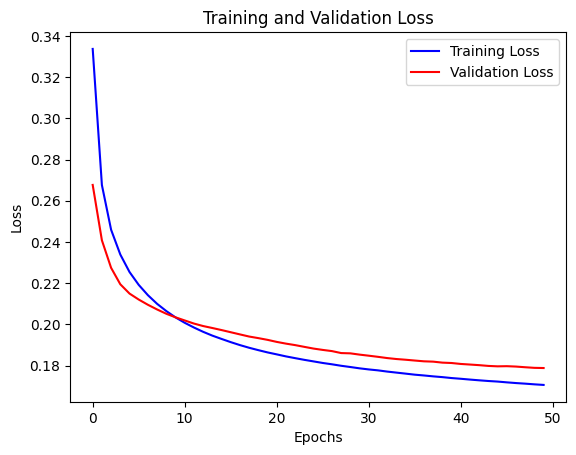

In [46]:
plt.figure()
plt.plot(range(len(TRAIN_LOSS_LIST)), TRAIN_LOSS_LIST, "b", label="Training Loss")
plt.plot(range(len(VAL_LOSS_LIST)), VAL_LOSS_LIST, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [41]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta: future = delta
    else: future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i: plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else: plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

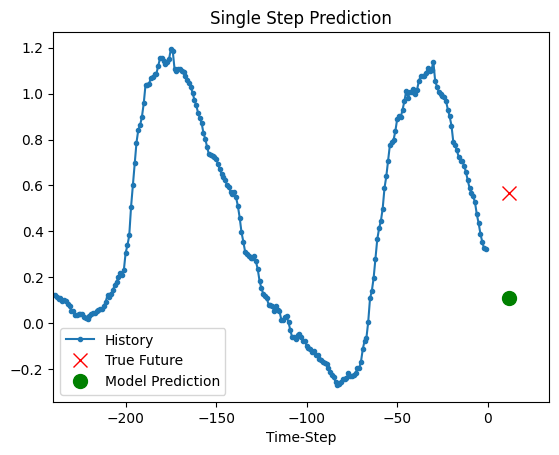

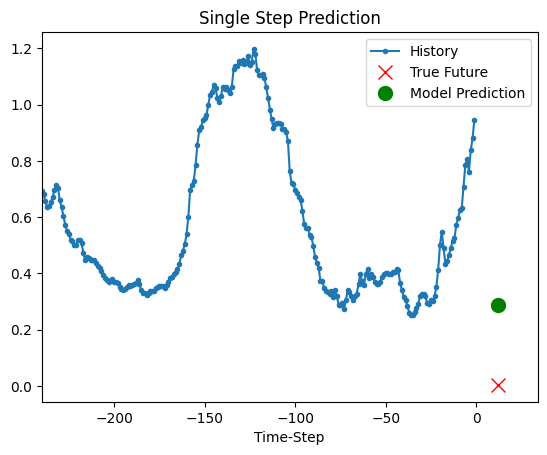

In [43]:
examples = 2

for X_batch, y_batch in ValidLoader:
    Neilson.eval()
    with torch.no_grad():
        predictions = Neilson(X_batch)

    if np.random.random() >= 0.5:
        examples -= 1
    
        show_plot(
            [X_batch[0][:, 1].numpy(), y_batch[0].numpy(), predictions[0]],
            delta = 12,
            title = "Single Step Prediction"
        )

    if not examples: break

This model is slightly more accurate at "predicting the future" than the classical model!